# Parameter Estimation - FHN model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy import integrate
from scipy.stats import gaussian_kde
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.models import GenerativeModel

## Simulator settings

In [2]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters:
    p_samples = np.random.uniform(low=-2, high=0, size=(batch_size, 3))
    return p_samples.astype(np.float32)

# ODE model 
def fhn_dynamics(t, x, theta):
    theta = 10**theta
    return np.array([theta[2]*(x[0]-1/3*x[0]**3+x[1]), -1/theta[2]*(x[0]-theta[0]+theta[1]*x[1])])

x0 = [-1, 1]
n_obs = 21 
t_end = 15
time_points = np.linspace(0, t_end, n_obs)
sigma = 0.05   # noise standard deviation
missing_max = 11

def batch_simulator_augment01(prior_samples, n_missing):
    """
    Simulate a batch of FHN data sets with n_missing missing values and binary indicator augmentation
    """    
    n_sim = prior_samples.shape[0]   # batch size 
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim data sets, each with n_obs observations

    for m in range(n_sim):
        rhs = lambda x,t: fhn_dynamics(t, x, prior_samples[m])
        sol = integrate.odeint(rhs, x0, time_points) 
        sim_data[m, :, 0] = sol[:,0] + np.random.normal(0, sigma, size=n_obs)

        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-5.0, 0.0])
    
    return sim_data

We build an amortized parameter estimation network.

In [3]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 3
}

In [4]:
# Augment by 0/1
summary_net = LSTM(64)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./FHN_augment01_5ACB_[64,64,64]_LSTM(64)_ckpts', skip_checks=True)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./FHN_augment01_5ACB_[64,64,64]_LSTM(64)_ckpts\ckpt-300


## Generate test data

In [5]:
# Test data sets
param_priors = np.array([[-0.8, -1.4, -1.3], [-1.0, -0.6, -0.1], [-1.7, -1.2, -1.6], [-1.3, -1.4, -0.9], [-0.3, -1.9, -0.8]])  
n_missings = np.array([10, 10, 5, 5, 0])
x_datas = batch_simulator_augment01(param_priors, n_missings)
np.save('x_datas.npy', x_datas)

In [5]:
# Load test data
param_priors = np.array([[-0.8, -1.4, -1.3], [-1.0, -0.6, -0.1], [-1.7, -1.2, -1.6], [-1.3, -1.4, -0.9], [-0.3, -1.9, -0.8]])  
x_datas = np.load("x_datas.npy")

In [6]:
# Select data to be shown
param_priors = param_priors[[0,1,3]]
x_datas = x_datas[[0,1,3]]

## Computational faithfulness

In [7]:
# Sample from BayesFlow
n_post_samples = 2000 
param_samples = amortizer.sample(x_datas, n_post_samples)

In [8]:
# Load MCMC samples
mcmc_samples = np.load("mcmc_samples.npy")
mcmc_samples = mcmc_samples[[0,1,3]]

## Posterior plot

In [9]:
def plot_posterior(param_samples, mcmc_samples, levels, param_names=["a", "b", "g"], cmap="viridis"):
    count = 1
    for i in range(0, param_samples.shape[1]):
        for j in range(0, param_samples.shape[1]):
            plt.subplot(param_samples.shape[1], param_samples.shape[1], count)
            if i != j:
                # kde for BayesFlow samples
                a = param_samples[:,i]
                b = param_samples[:,j]
                ab = np.vstack([a, b])
                z = gaussian_kde(ab)(ab)
                ida = z.argsort()  # Sort the points by density, so that the densest points are plotted last
                a, b, z = a[ida], b[ida], z[ida]
                plt.scatter(a, b, c=z, s=10, cmap=cmap, alpha=0.2)
                # levels sets from MCMC samples
                sns.kdeplot(x=mcmc_samples[:,i], y=mcmc_samples[:,j], levels=levels[i,j], cmap="viridis")
                plt.xlabel('Parameter ${}$'.format(param_names[i]))
                plt.ylabel('Parameter ${}$'.format(param_names[j]))            
            else:
                plt.hist(param_samples[:,i], bins='auto', density=1, color='orange', label='BayesFlow (marginal)')
                sns.kdeplot(mcmc_samples[:,i], color='tab:blue')
                plt.ylabel('Marginal density')
                plt.xlabel('Parameter ${}$'.format(param_names[i])) 
            if i == 1 and j == 2:                    
                legend_elements = [
                    Line2D([0], [0], color="tab:blue", lw=1, label="MCMC (marginal)"),
                    Line2D([0], [0], color="orange", markerfacecolor="orange", marker="s", lw=0, markersize=6, label="BayesFlow (marginal)"),
                    Line2D([0], [0], color="purple", lw=1, label="MCMC (2D joint)"),
                    Line2D([0], [0], color="purple", markerfacecolor="purple", marker="o", lw=0, markersize=6, alpha=0.2, label="BayesFlow (2D joint)"),
                ]
                plt.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1,0.5))                    
            count += 1

In [10]:
levels = np.array([[[0,7,7],[7,0,3],[7,3,0]],
                   [[0,6,6],[6,0,6],[6,6,0]],
                   [[0,7,7],[7,0,3],[7,3,0]]])

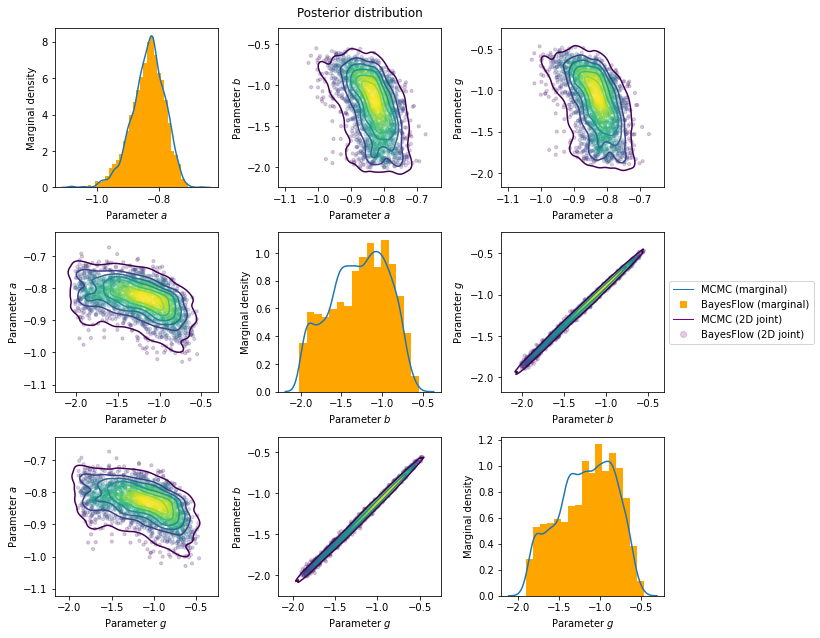

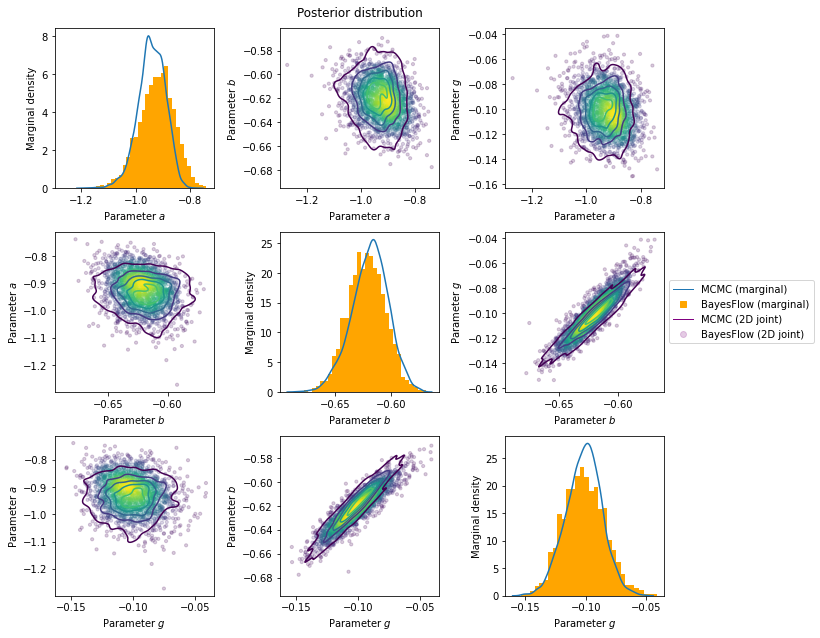

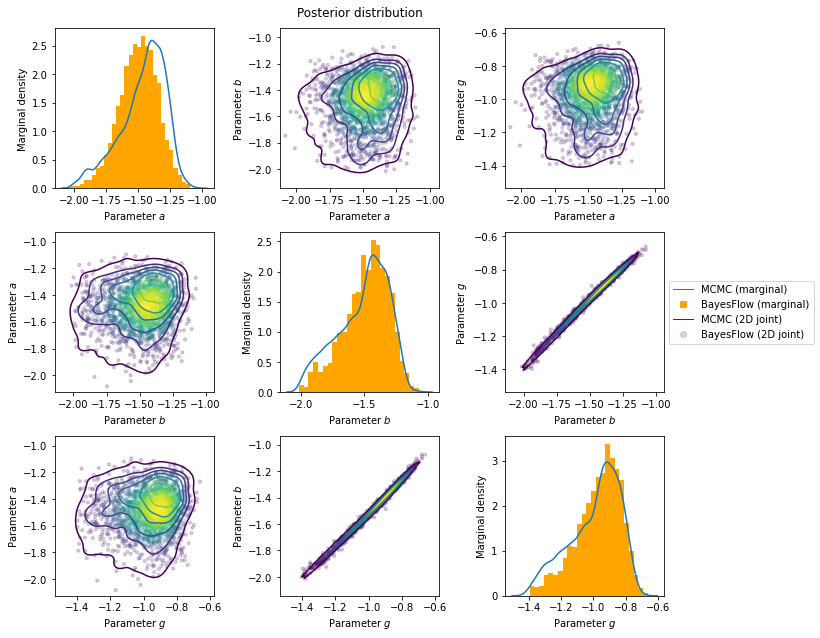

In [11]:
for k in range(len(x_datas)):
    fig = plt.subplots(3, 3, figsize=(11.5, 9))
    plot_posterior(param_samples[k], mcmc_samples[k][5000:10000], levels[k])
    plt.suptitle("Posterior distribution                          ")
    plt.tight_layout()
    plt.savefig("figures/FHN_augment01_{}.png".format(k+1), dpi=300, bbox_inches='tight')
    plt.savefig("figures/FHN_augment01_{}.pdf".format(k+1), bbox_inches='tight')

## Posterior predictive check

In [23]:
def plot_predictive_check(ax, param_prior, x_data, param_samples, n_sim=1000):
    
    time_avail = time_points[x_data[:,1]==1]
    x_avail = x_data[x_data[:,1]==1, 0]
    
    grid = 101
    time_line = np.linspace(0, t_end, grid) 
    traj_sim = np.empty((n_sim, grid))

    for k in range(n_sim):
        rhs = lambda x,t: fhn_dynamics(t, x, param_samples[k])
        sol = integrate.odeint(rhs, x0, time_line)  
        traj_sim[k] = sol[:,0] + np.random.normal(0, sigma, size=grid)
        
    traj_mean = np.mean(traj_sim, axis=0)
    traj_quantiles = np.quantile(traj_sim, [0.05, 0.95], axis=0)
    
    ax.plot(time_line, traj_mean, color='tab:orange', label='Simulated mean')
    ax.fill_between(time_line, traj_quantiles[0], traj_quantiles[1], color='tab:orange', alpha=.25, label='90% CI')
    
    rhs = lambda x,t: fhn_dynamics(t, x, param_prior)
    sol = integrate.odeint(rhs, x0, time_line)
    ax.plot(time_line, sol[:,0], color='black', linestyle='dashed', label='True trajectory') 
    ax.plot(time_avail, x_avail, 'o', color='tab:blue', markersize=4.5, label='Available data')
        
    ax.set_xlabel('Time $t$')
    ax.set_ylabel("Measurement $y$")
    ax.set_title("Posterior predictive check")

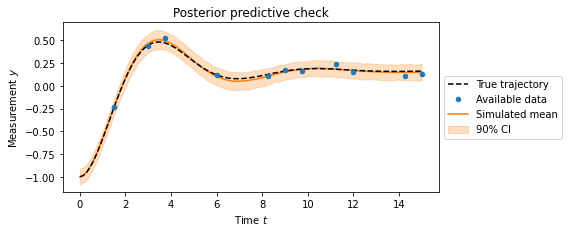

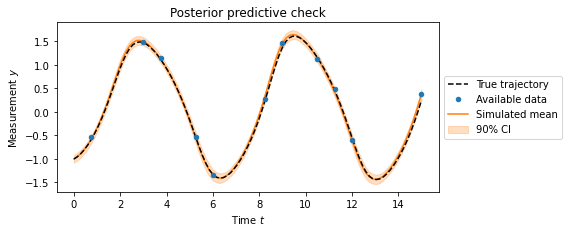

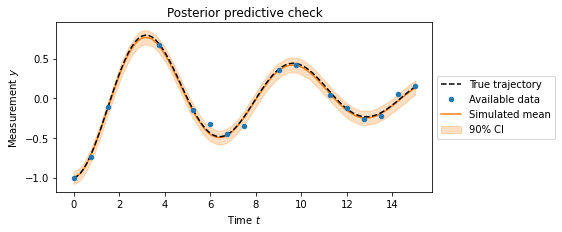

In [24]:
for j in range(len(x_datas)):
    fig, ax = plt.subplots(figsize=(8, 10/3))
    plot_predictive_check(ax, param_priors[j], x_datas[j], param_samples[j])  
    handles, labels = ax.get_legend_handles_labels()
    order = [2,3,0,1]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="center left", bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    for fmt in ["png", "pdf"]:
        fig.savefig(f"figures/FHN_augment01_predictive_{j+1}.{fmt}", dpi=300, bbox_inches='tight')